# Similarity Matching

In [2]:
# Load Installation
%run setup.py

In [115]:
df_Invited = pd.read_csv(os.path.join(filepath,'factInvited.csv'))
df_Invited['Source'] = "Invited"

df_Proceedings = pd.read_csv(os.path.join(filepath,'factProceedings.csv'))
df_Proceedings['Source'] = "Proceedings"

# # Append data to one dataframe
df = pd.concat([df_Proceedings,df_Invited], sort=False, axis=0)
df = df[df['Productivity'] != 0].reset_index(drop=True)
df['log(Paper Count)'] = np.log(df['Paper Count'])
df['idx'] = df.index

def map_age_group(age_range):
    if age_range >=  20:
        return '>20'
    elif age_range >= 15:
        return '15-20'
    elif age_range >= 10:
        return '10-15'
    elif age_range >= 5:
        return '5-10'
    else:
        return '0-5'
    
df['Age Group'] = df['Age'].apply(map_age_group)

df.head(3)

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,column_equal,Paper Count,Max Paper Count,First year paper,ID,Age,Productivity,Conference (long),Main Topic,Source,log(Paper Count),idx,Age Group
0,Aaron Gage,2004,AAAI,Aaron,NaN,Gage,M,True,7,8,1999,Aaron Gage_1,5,1.400000,AAAI Conference on Artificial Intelligence,Artificial Intelligence,Proceedings,1.945910,0,5-10
1,Abhi Shelat,2004,AAAI,Abhi,NaN,Shelat,M,True,7,75,2002,Abhi Shelat_1,2,3.500000,AAAI Conference on Artificial Intelligence,Artificial Intelligence,Proceedings,1.945910,1,0-5
2,Adele E. Howe,2004,AAAI,Adele,E.,Howe,F,True,48,91,1986,Adele E. Howe_1,18,2.666667,AAAI Conference on Artificial Intelligence,Artificial Intelligence,Proceedings,3.871201,2,15-20


# Similarity on gender

## Define Function

In [83]:
def Nearest_Neighbor(df,k,q,n):
    df_F = df[df['gender'] == 'F'].reset_index(drop=True)
    df_M = df[df['gender'] == 'M']

    nbrs = NearestNeighbors(n_neighbors=k).fit(df_F[['log(Paper Count)','Productivity','Age']])
    distances, indices = nbrs.kneighbors(df_M[['log(Paper Count)','Productivity','Age']])
    
    # Find threshold
    threshold = np.quantile(distances.flatten(),q=q)
    mask = distances <= threshold
    filtered_indices = indices.copy().astype(float)
    filtered_indices[~mask] = np.nan
    
    # Initiliaze ratio list
    ratio_list = []
    
    for i in range(0,n):
        results = df_M.copy()
        results['Similar idx'] = [random.choice(row) for row in indices.tolist()] # select index
        results = results.dropna(subset=['Similar idx'])
        results = results.merge(right = df_F, left_on='Similar idx', right_index=True, how='left',suffixes=['_M','_F']) # merge info
        
        try:
            P_males_inv = results['Source_M'].value_counts(normalize=True).loc['Invited']
            P_females_inv = results['Source_F'].value_counts(normalize=True).loc['Invited']
            ratio = np.divide(P_females_inv,P_males_inv)
            # ratio = np.divide(P_females_inv - P_males_inv, P_males_inv)
            ratio_list.append(ratio)
        except:
            ratio_list.append(np.nan)
            continue
    
    mean_ratio = np.nanmean(ratio_list)
    std_ratio = np.nanstd(ratio_list)
    
    return mean_ratio,std_ratio
    # return ratio_list

In [16]:
def KNN_distance(df, k, q, ax=None):
    df_F = df[df['gender'] == 'F'].reset_index(drop=True)
    df_M = df[df['gender'] == 'M']

    nbrs = NearestNeighbors(n_neighbors=k).fit(df_F[['log(Paper Count)','Productivity','Age']])
    distances, indices = nbrs.kneighbors(df_M[['log(Paper Count)','Productivity','Age']])
    
    # Find threshold
    threshold = np.quantile(distances.flatten(),q=q)
    
    # Use the provided subplot (if any)
    if ax is not None:
        ax.hist(distances.flatten(),bins=100)
        height = max(np.histogram(distances.flatten(),bins=100)[0])
        ax.vlines(threshold,0,height,colors="C1",linestyles="dashed",label='Threshold',linewidth=2.5)
        ax.set_title(str(df['Year'].unique()[0]) + ' and age group ' + str(df['Age Group'].unique()[0]) + ' for k = ' + str(k) + ' and q = ' + str(q),fontsize=14)
        ax.set_xlabel('Distance')
        ax.set_ylabel('Frequency')
        ax.legend()
        plt.tight_layout()

## Plot Nearest Neighbor with 1,5 and 10 neighbors

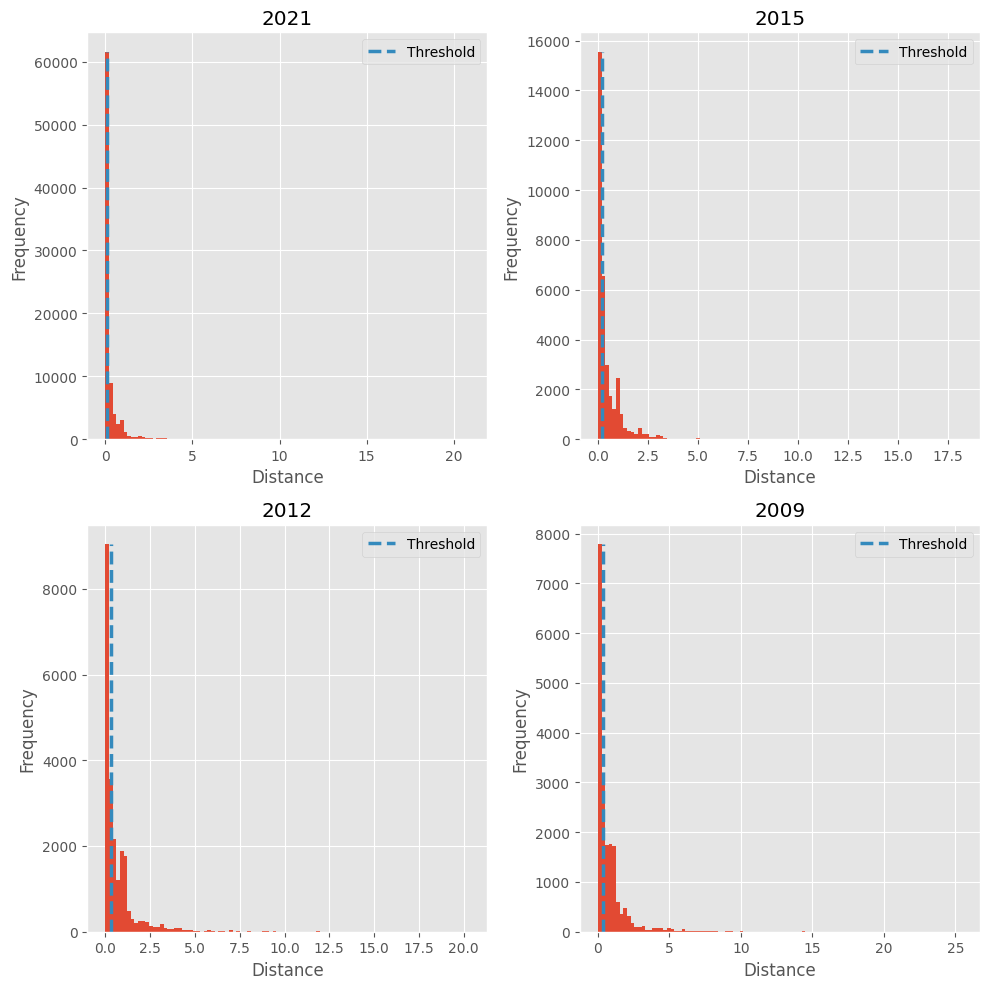

In [62]:
year_list = np.random.choice(range(2003,2023),size=4,replace=False)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))


for id,year in enumerate(year_list):
    df_year = df[df['Year'] == year]
    ax = axs[id//2][id%2]
    KNN_distance(df_year,k=5, q=0.5, ax=ax) # write that k=5, q=0.5

100%|██████████| 20/20 [04:24<00:00, 13.20s/it]


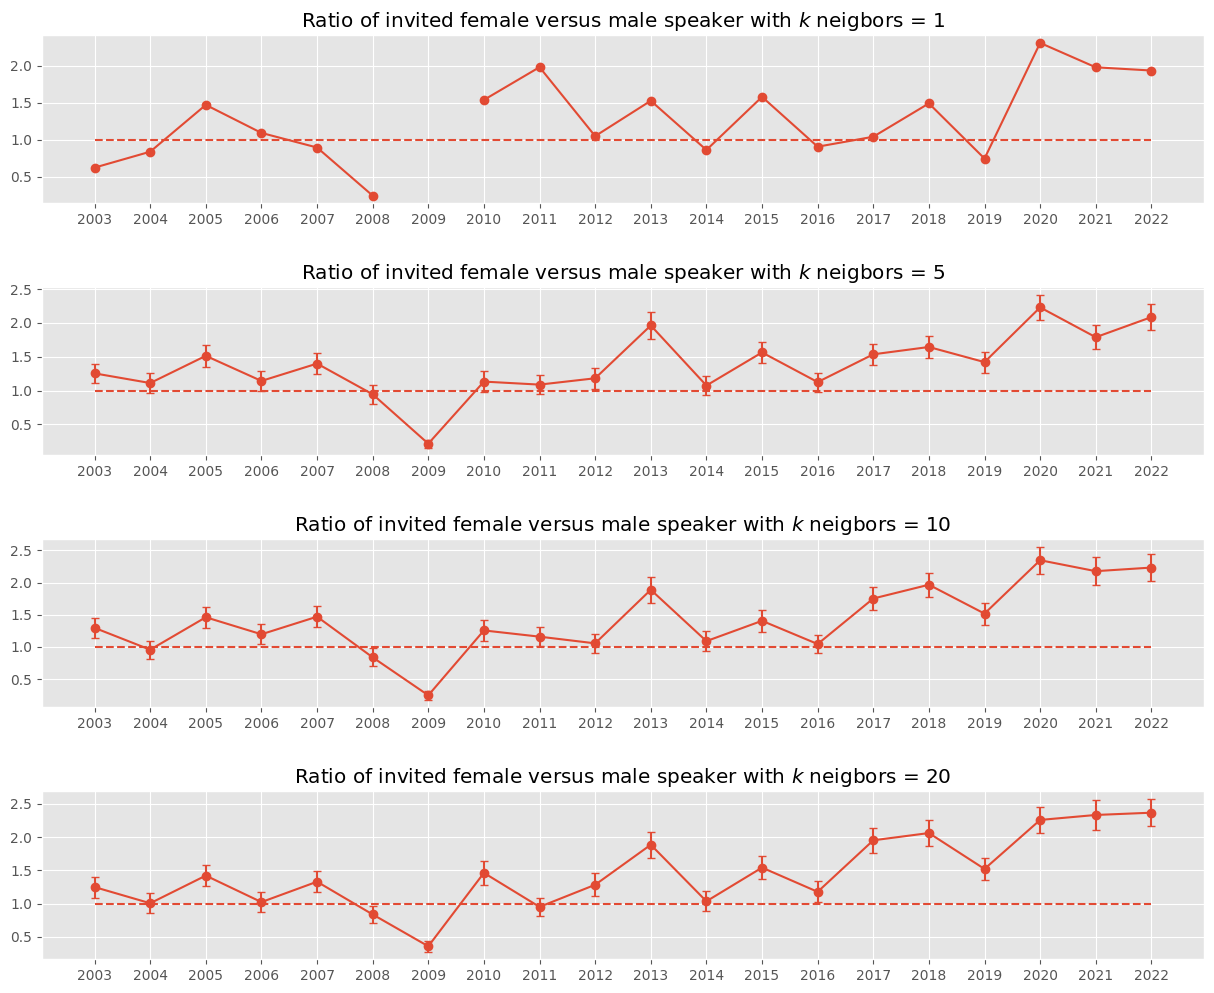

In [4]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
k_list = [1,5,10,20]

for n, k in enumerate(k_list):
    ax = plt.subplot(len(k_list), 1, n + 1)
    # ax.plot(df['Age'],'o',alpha=0.1)
    
    ratio_list = []
    std_list = []
    for year in tqdm(range(2003,2023)):
        try:
            df_year = df[df['Year'] == year]
            mean_ratio, std_ratio = Nearest_Neighbor(df_year,k=k, q=0.5, n=1000)
            ratio_list.append(mean_ratio)
            std_list.append(std_ratio)
        except: 
            ratio_list.append(np.NaN)
            std_list.append(np.NaN)
            continue
        
    ax.errorbar(range(2003,2023), ratio_list, yerr=std_list, fmt='o-', capsize=3,label="Adj. Ratio")
    ax.set_title('Ratio of invited female versus male speaker with $k$ neigbors = ' + str(k))
    ax.set_xticks(range(2003,2023,1))
    ax.hlines(1, 2003, 2022, linestyles='dashed')
    

## Heatmap 3D

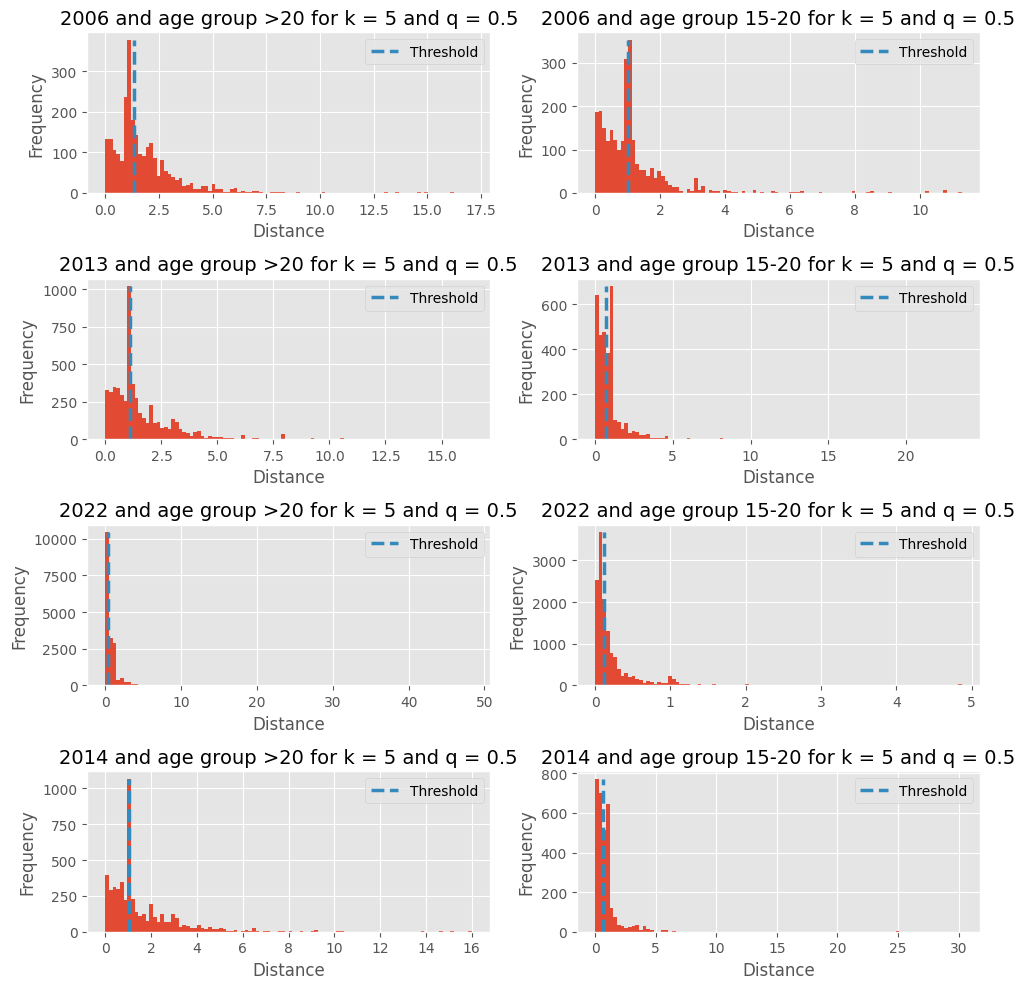

In [17]:
year_list = np.random.choice(range(2003,2023),size=4,replace=False)
age_list = np.random.choice(df['Age Group'].unique(),2,replace=False)
fig, axs = plt.subplots(4, 2, figsize=(10, 10))


for id_x, year in enumerate(year_list):
    for id_y, age in enumerate(age_list):
        df_filtered = df[(df['Age Group'] == age) & (df['Year'] == year)]
        ax = axs[id_x][id_y]
        KNN_distance(df_filtered,k=5, q=0.5, ax=ax) # write that k=5, q=0.5

In [18]:
ratio_list = []
for year in tqdm(range(2003,2023)):
    for age in df['Age Group'].unique(): 
        df_filtered = df[(df['Age Group'] == age) & (df['Year'] == year)]
        
        ratio_mean, _ = Nearest_Neighbor(df_filtered, k=10, q=0.5, n=1000)
        ratio_list.append(ratio_mean)
    
ratio_list = np.array(ratio_list).reshape(20,5)
# ratio_list

100%|██████████| 20/20 [05:57<00:00, 17.86s/it]


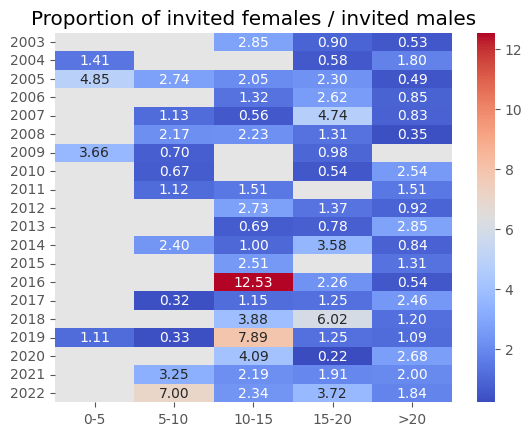

In [22]:
df_pivot = pd.DataFrame(ratio_list, columns=df['Age Group'].unique(), index=range(2003,2023))
age_group_order = ['0-5', '5-10', '10-15', '15-20', '>20']
df_pivot = df_pivot.reindex(columns=age_group_order)

# Plot
# plt.figure(figsize=(15, 12))
sns.heatmap(df_pivot, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Proportion of invited females / invited males')
plt.show()

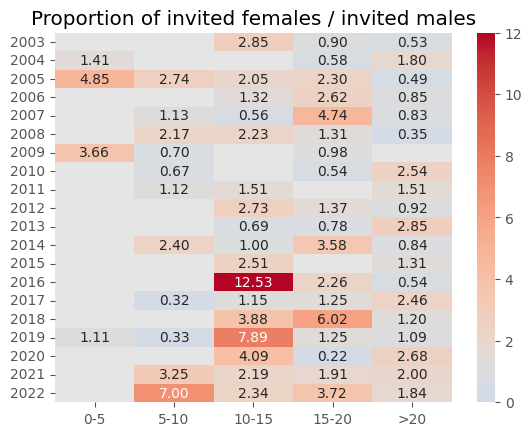

In [80]:
 # plt.figure(figsize=(15, 12))
sns.heatmap(df_pivot, cmap='coolwarm', annot=True, fmt='.2f', center = 1, vmin = 0, vmax = 12)
plt.title('Proportion of invited females / invited males')
plt.show()

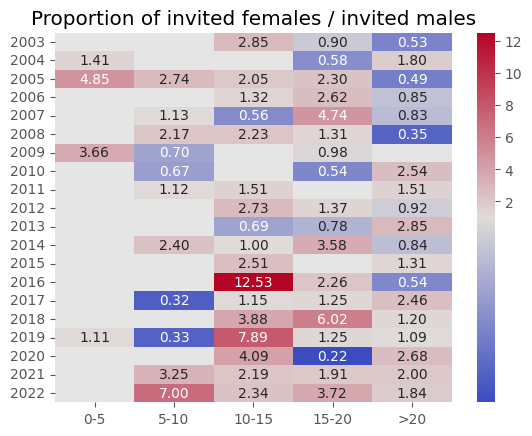

In [78]:
import matplotlib as mpl

# Get the blue and red colors from coolwarm colormap
coolwarm_cmap = mpl.cm.get_cmap('coolwarm')
blue_color = coolwarm_cmap(0.0)
middel_color = coolwarm_cmap(0.51)
red_color = coolwarm_cmap(1.0)

# Define the new colormap with blue at the lower end and red at the higher end
colors = [blue_color, middel_color, red_color]
new_cmap = mpl.colors.LinearSegmentedColormap.from_list("", colors)

# Set the center of the colormap to 1
midpoint = 1.0
vmin, vmax = df_pivot.min().min(), df_pivot.max().max()
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=midpoint, vmax=vmax)

# Plot
sns.heatmap(df_pivot, cmap=new_cmap, annot=True, fmt='.2f', norm=norm)
plt.title('Proportion of invited females / invited males')
plt.show()

In [84]:
# New ratio (I_F - I_M) / I_M
ratio_list = []
for year in tqdm(range(2003,2023)):
    for age in df['Age Group'].unique(): 
        df_filtered = df[(df['Age Group'] == age) & (df['Year'] == year)]
        
        ratio_mean, _ = Nearest_Neighbor(df_filtered, k=10, q=0.5, n=1000)
        ratio_list.append(ratio_mean)
    
ratio_list = np.array(ratio_list).reshape(20,5)
# ratio_list

100%|██████████| 20/20 [05:46<00:00, 17.34s/it]


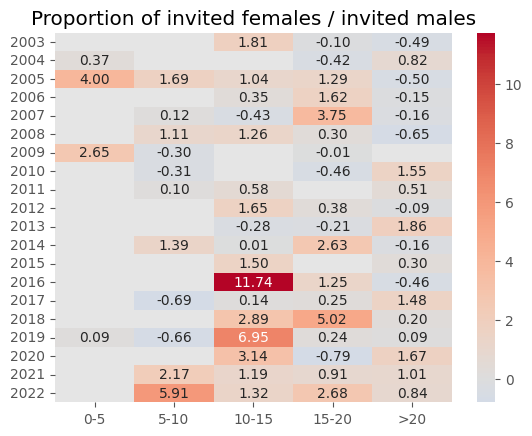

In [86]:
df_pivot = pd.DataFrame(ratio_list, columns=df['Age Group'].unique(), index=range(2003,2023))
age_group_order = ['0-5', '5-10', '10-15', '15-20', '>20']
df_pivot = df_pivot.reindex(columns=age_group_order)

# Plot
# plt.figure(figsize=(15, 12))
sns.heatmap(df_pivot, cmap='coolwarm', annot=True, fmt='.2f', center = 0)
plt.title('Proportion of invited females / invited males')
plt.show()

## Heatmap 2D (age group)

In [50]:
ratio_list = []
age_group_order = ['0-5', '5-10', '10-15', '15-20', '>20']
for age in tqdm(age_group_order):
    df_filtered = df[df['Age Group'] == age]
    
    ratio_mean, _ = Nearest_Neighbor(df_filtered, k=10, q=0.9, n=1000, print_results=False)
    ratio_list.append(ratio_mean)
    
# ratio_list = np.array(ratio_list).reshape(20,5)
# ratio_list

100%|██████████| 5/5 [04:48<00:00, 57.76s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

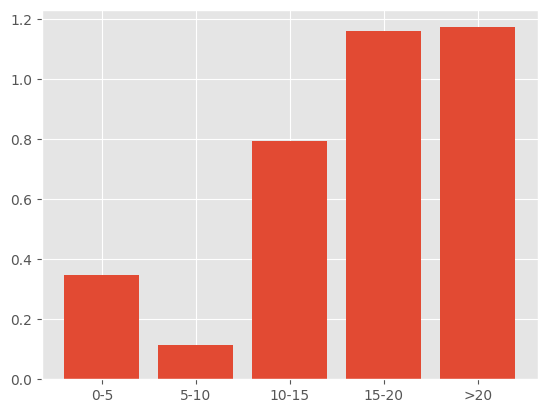

In [53]:
plt.bar(age_group_order,ratio_list)
plt.show

# Similarity on source

In [102]:
# Takes ~1 minute
total_list = []
for year in tqdm(range(2003,2023)):
    df_filtered = df[df['Year'] == year]
    df_inv = df_filtered[df_filtered['Source'] == 'Invited'].reset_index(drop=True)

    nbrs = NearestNeighbors(n_neighbors=5).fit(df_inv[['log(Paper Count)','Productivity','Age']])
    distances, indices = nbrs.kneighbors(df_filtered[['log(Paper Count)','Productivity','Age']])

    # Find threshold
    threshold = np.quantile(distances.flatten(),q=0.5)
    mask = distances <= threshold
    filtered_indices = indices.copy().astype(float)
    filtered_indices[~mask] = np.nan
    
    mean_list = []
    for i in range(0,len(indices)):
        try:
            # Takes the indices of the 5 nearest neighbors and removes the NaN values
            new_list = filtered_indices[i][~np.isnan(filtered_indices[i])]
            # Finds the ratio of females of the 5 nearest invited neighbors
            mean = df_inv.loc[new_list,'gender'].value_counts(normalize=True)['F']
            mean_list.append(mean)
        except:
            mean_list.append(np.nan)
            continue
    total_list.append(np.nanmean(mean_list))

100%|██████████| 20/20 [01:18<00:00,  3.93s/it]


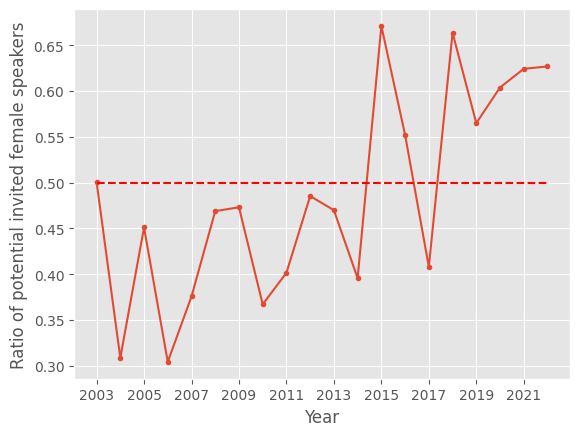

In [114]:
plt.plot(range(2003,2023),total_list,marker='.')
plt.xticks(range(2003,2023,2))
plt.xlabel('Year')
plt.ylabel('Ratio of potential invited female speakers')
plt.hlines(0.5,2003,2022,linestyles='dashed',colors='red')
plt.show()

In [88]:
# takes 1-2 minutes
mean_list = []
for i in tqdm(range(0,len(indices))):
    try:
        new_list = filtered_indices[i][~np.isnan(filtered_indices[i])]
        mean = df_inv.loc[new_list,'gender'].value_counts(normalize=True)['F']
        mean_list.append(mean)
    except:
        mean_list.append(np.nan)
        continue

100%|██████████| 180003/180003 [01:23<00:00, 2152.08it/s]


In [89]:
df['ratio'] = mean_list

In [90]:
np.nanmean(mean_list)

0.5056911630335466

In [91]:
df.head()

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,column_equal,Paper Count,Max Paper Count,...,ID,Age,Productivity,Conference (long),Main Topic,Source,log(Paper Count),idx,Age Group,ratio
0,Aaron Gage,2004,AAAI,Aaron,NaN,Gage,M,True,7,8,...,Aaron Gage_1,5,1.400000,AAAI Conference on Artificial Intelligence,Artificial Intelligence,Proceedings,1.945910,0,5-10,0.6
1,Abhi Shelat,2004,AAAI,Abhi,NaN,Shelat,M,True,7,75,...,Abhi Shelat_1,2,3.500000,AAAI Conference on Artificial Intelligence,Artificial Intelligence,Proceedings,1.945910,1,0-5,NaN
2,Adele E. Howe,2004,AAAI,Adele,E.,Howe,F,True,48,91,...,Adele E. Howe_1,18,2.666667,AAAI Conference on Artificial Intelligence,Artificial Intelligence,Proceedings,3.871201,2,15-20,0.4
3,Akihiro Kishimoto,2004,AAAI,Akihiro,NaN,Kishimoto,M,True,4,62,...,Akihiro Kishimoto_1,2,2.000000,AAAI Conference on Artificial Intelligence,Artificial Intelligence,Proceedings,1.386294,3,0-5,0.5
4,Al Globus,2004,AAAI,Al,NaN,Globus,M,True,6,6,...,Al Globus_1,14,0.428571,AAAI Conference on Artificial Intelligence,Artificial Intelligence,Proceedings,1.791759,4,10-15,NaN


In [92]:
df_plot = df[~df['ratio'].isna()]

<AxesSubplot: xlabel='Year'>

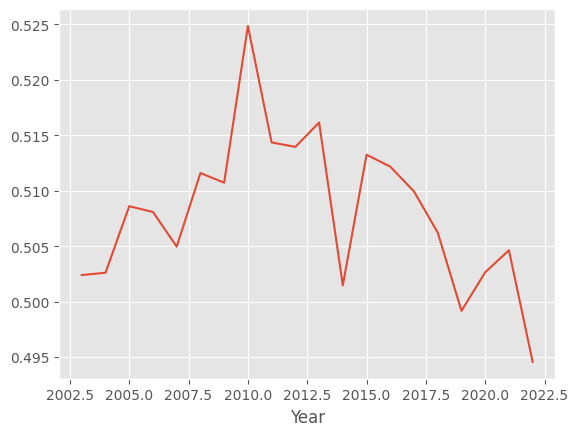

In [93]:
df_plot.groupby('Year')['ratio'].mean().plot()

<AxesSubplot: >

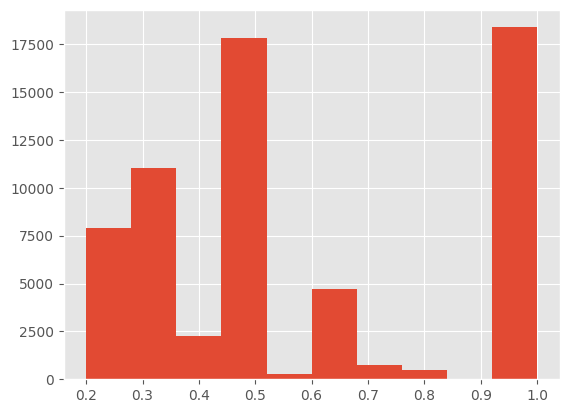

In [70]:
df['ratio'].hist(bins=10)

# Similarity Test

In [74]:
name_list = df[(df['Source'] == "Invited") & (df['gender'] == "M")]['Full name'].value_counts().head(10)
name_list

Tim Berners-Lee           9
Prabhakar Raghavan        7
Michael Kearns            4
David Haussler            4
Oren Etzioni              4
Yann LeCun                4
Josh Tenenbaum            4
Christos Papadimitriou    4
Jon Kleinberg             4
Martin Grohe              3
Name: Full name, dtype: int64

In [90]:
df_M.Year.unique()

array([2004, 2006, 2007, 2010, 2014, 2016, 2017, 2019, 2020, 2021, 2022,
       2009, 2012, 2013, 2018, 2003, 2005, 2011, 2008, 2015], dtype=int64)

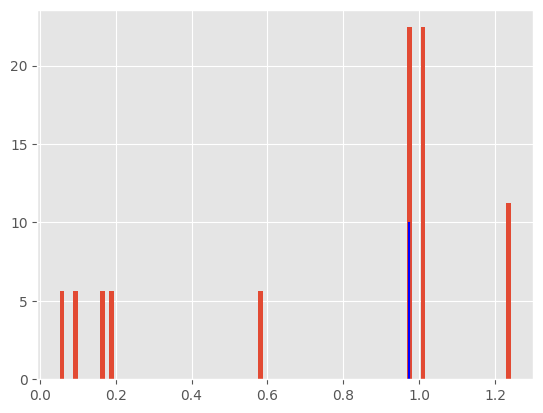

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,column_equal,Paper Count,Max Paper Count,First year paper,ID,Age,Productivity,Conference (long),Main Topic,Source,log(Paper Count),idx,Age Group
179233,Yann LeCun,2012,ICML,Yann,NaN,LeCun,M,NaN,119,205,1988,NaN,24,4.958333,International Conference on Machine Learning,Artificial Intelligence,Invited,4.779123,179233,>20
179395,Michael Kearns,2012,KDD,Michael,NaN,Kearns,M,NaN,146,189,1987,NaN,25,5.840000,Conference on Knowledge Discovery and Data Mining,Data Management,Invited,4.983607,179395,>20
179678,Martin Grohe,2012,SODA,Martin,NaN,Grohe,M,NaN,127,209,1993,NaN,19,6.684211,Symposium on Discrete Algorithms,Algorithm and Theory,Invited,4.844187,179678,15-20
179731,Michael Kearns,2012,STOC,Michael,NaN,Kearns,M,NaN,146,189,1987,NaN,25,5.840000,Symposium on Theory of Computing,Algorithm and Theory,Invited,4.983607,179731,>20
179856,Tim Berners-Lee,2012,WWW,Tim,NaN,Berners-Lee,M,NaN,41,57,1988,NaN,24,1.708333,World Wide Web Conference,Data Management,Invited,3.713572,179856,>20


In [130]:
df1 = df[df['Year'] == 2012]
df_F = df1[df1['gender'] == 'F'].reset_index(drop=True)
df_M = df1[(df1['Full name'].isin(name_list.index)) & (df1['Source'] == "Invited")]

nbrs = NearestNeighbors(n_neighbors=3).fit(df_F[['log(Paper Count)','Productivity','Age']])
distances, indices = nbrs.kneighbors(df_M[['log(Paper Count)','Productivity','Age']])

# Find threshold
threshold = np.quantile(distances.flatten(),q=0.5)
plt.hist(distances.flatten(),bins=100,density=True)
plt.vlines(threshold,0,10,color = "blue")
plt.show()
mask = distances <= threshold

filtered_indices = indices.copy().astype(float)
filtered_indices[~mask] = np.nan
df_M

In [132]:
distances

array([[0.16991409, 1.00576097, 1.00838049],
       [0.97198886, 0.97198886, 1.24121336],
       [0.05321277, 0.58599305, 1.01156403],
       [0.97198886, 0.97198886, 1.24121336],
       [0.09598373, 0.19574385, 1.00382084]])

In [131]:
filtered_indices

array([[206.,  nan,  nan],
       [603., 941.,  nan],
       [551., 838.,  nan],
       [603., 941.,  nan],
       [301., 131.,  nan]])

In [142]:
df_F.loc[131]

Full name                                              Xing Chen
Year                                                        2012
Conference (short)                                          AAAI
First name                                                  Xing
Middle name                                                  NaN
Last name                                                   Chen
gender                                                         F
column_equal                                                True
Paper Count                                                   37
Max Paper Count                                              153
First year paper                                            1988
ID                                                   Xing Chen_1
Age                                                           24
Productivity                                            1.541667
Conference (long)     AAAI Conference on Artificial Intelligence
Main Topic               

In [ ]:
# Initiliaze ratio list
ratio_list = []

for i in range(0,n):
    results = df_M.copy()
    results['Similar idx'] = [random.choice(row) for row in indices.tolist()] # select index
    results = results.dropna(subset=['Similar idx'])
    results = results.merge(right = df_F, left_on='Similar idx', right_index=True, how='left',suffixes=['_M','_F']) # merge info
    
    try:
        P_males_inv = results['Source_M'].value_counts(normalize=True).loc['Invited']
        P_females_inv = results['Source_F'].value_counts(normalize=True).loc['Invited']
        ratio = np.divide(P_females_inv,P_males_inv)
        ratio_list.append(ratio)
    except:
        ratio_list.append(np.nan)
        continue

mean_ratio = np.nanmean(ratio_list)
std_ratio = np.nanstd(ratio_list)

return mean_ratio,std_ratio
# return ratio_list